# Exercise - TensorRT ONNX Conversion
Through this excersice you are requested to optimize YoloV5 convolutional neural network with TensorRT using the ONNX Parser and TensorRT Python SDK.

YoloV5 Github - https://github.com/ultralytics/yolov5

YoloV5 is a detection network with convolutional architecture, it was and still top of the class detector with realtime performance.

## Setup
Clone YoloV5 repository

In [ ]:
!rm -rf yolov5 && git clone https://github.com/ultralytics/yolov5.git

Setup requirements for execution

In [ ]:
!cd yolov5 && pip install -r requirements.txt
!apt update && apt install libgl1-mesa-glx -y #opencv dependencies

### Objective I
Convert the YoloV5 network to ONNX format, use the YoloV5 documentation to check on how to do so.

In [ ]:
!pip install onnx coremltools
!python yolov5/export.py

Simplify ONNX model to not fail TensorRT ONNX parser

In [ ]:
!pip install onnx-simplifier
!python -m onnxsim yolov5s.onnx yolov5s-simple.onnx

In [ ]:
!pip install netron
!netron yolov5s-simple.onnx --port 8890 --host 0.0.0.0

## Objective II - Convert the ONNX model to TensorRT Engine

#### Parse the ONNX model & build engine

In [ ]:
import tensorrt as trt

logger = trt.Logger(trt.Logger.VERBOSE)
logger.min_severity = trt.Logger.Severity.VERBOSE
EXPLICIT_BATCH = []

print('trt version', trt.__version__)
if trt.__version__[0] >= '7':
    EXPLICIT_BATCH.append(1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))

with trt.Builder(logger) as builder, builder.create_network(*EXPLICIT_BATCH) as network, trt.OnnxParser(network, logger) as parser:
    builder.max_workspace_size = 1 << 28
    builder.max_batch_size = 1
    conf = builder.create_builder_config()
#     builder.fp16_mode = True

    with open('yolov5s.onnx', 'rb') as f:
        if not parser.parse(f.read()):
            for error in range(parser.num_errors):
                print(parser.get_error(error))
        else:
            print("Parsed ONNX successfully")

    # reshape input from 32 to 1
    shape = list(network.get_input(0).shape)
    print("building tensorrt engine")
    engine = builder.build_engine(network, conf)
    print("Saving serialized model")
    with open('optimized.trt', 'wb') as f:
        f.write(engine.serialize())
        
    print("Done")

## Objective III - Inference with the resulting engine

In [1]:
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt

logger = trt.Logger(trt.Logger.VERBOSE)
logger.min_severity = trt.Logger.Severity.VERBOSE

class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        """Within this context, host_mom means the cpu memory and device means the GPU memory
        """
        self.host = host_mem 
        self.device = device_mem
    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()
    

def allocate_buffers(engine):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream

def load_engine(engine_path):
    with open(engine_path, "rb") as f, trt.Runtime(logger) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

engine = load_engine('./optimized.trt')

ctx = engine.create_execution_context()

# Allocate buffers for input and output
inputs, outputs, bindings, stream = allocate_buffers(engine) # input, output: host # bindings 



In [2]:
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer data from CPU to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]


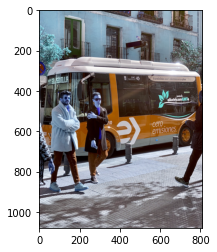

In [3]:
import cv2
import requests
import matplotlib.pyplot as plt
import numpy as np

r = requests.get('https://github.com/ultralytics/yolov5/blob/master/data/images/bus.jpg?raw=true', allow_redirects=True)
open('bus.jpg', 'wb').write(r.content)

image = cv2.imread('bus.jpg')
resized = cv2.resize(image, (640,640))
img_in = np.transpose(resized, (2, 0, 1)).astype(np.float32)
img_in = np.expand_dims(img_in, axis=0)
img_in /= 255

plt.figure()
plt.imshow(image)

In [4]:
import numpy as np
import math
import torch

max_batch_size = 1 # The batch size of input mush be smaller the max_batch_size once the engine is built

np.copyto(inputs[0].host, img_in.ravel())

outputs = do_inference(ctx, bindings, inputs, outputs, stream)

# Print the shape of each output
for output in outputs:
    out = np.asanyarray(output).reshape(1, int(len(output) / 85), 85)
    print(out.shape)

out_concat = np.asanyarray(outputs[3]).reshape(1, int(len(outputs[3]) / 85), 85)


(1, 19200, 85)
(1, 4800, 85)
(1, 1200, 85)
(1, 25200, 85)


In [5]:
# According to this solution: https://stackoverflow.com/questions/65824714/process-output-data-from-yolov5-tflite

def classFilter(classdata):
    classes = []  # create a list
    for i in range(classdata.shape[0]):         # loop through all predictions
        classes.append(classdata[i].argmax())   # get the best classification location
    return classes  # return classes (int)

def YOLOdetect(output_data):  # input = interpreter, output is boxes(xyxy), classes, scores
    output_data = output_data[0]                # x(1, 25200, 7) to x(25200, 7)
    boxes = np.squeeze(output_data[..., :4])    # boxes  [25200, 4]
    scores = np.squeeze( output_data[..., 4:5]) # confidences  [25200, 1]
    classes = classFilter(output_data[..., 5:]) # get classes
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    x, y, w, h = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3] #xywh
    xyxy = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]  # xywh to xyxy   [4, 25200]

    return xyxy, classes, scores  # output is boxes(x,y,x,y), classes(int), scores(float) [predictions length]

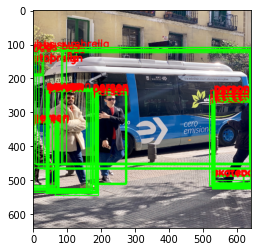

In [8]:
xyxy, classes, scores = YOLOdetect(out_concat) #boxes(x,y,x,y), classes(int), scores(float) [25200]

classes_arr = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']
output = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)

for i in range(len(scores)):
    if ((scores[i] > 0.1) and (scores[i] <= 1.0)):
        cv2.rectangle(output, (int(xyxy[0][i]),int(xyxy[1][i])), (int(xyxy[2][i]),int(xyxy[3][i])), (10, 255, 0), 2)
        output = cv2.putText(output, classes_arr[classes[i]], (int(xyxy[0][i]),int(xyxy[1][i])), cv2.FONT_HERSHEY_SIMPLEX, 
                           1, (255, 0, 0), 2, cv2.LINE_AA)

plt.figure()
plt.imshow(output)